Rad229_EPI_OffRes_Dist_Demo.ipynb demonstrates off-resonance distortion echo planar imaging (EPI). 

You can adjust the kind (constant, linear, quadratic) of off-resonance and the EPI trajectory (top-down vs. bottom-up)

These questions can be used to further explore the code and concepts.

1. Define a CONSTANT off-resonance field for a top-down EPI trajectory. Compare positive and negative off-resonance frequencies.
    
    a. What happens to the object? Why?

    b. Explain what you observe from a k-space perspective?

1. Compare LINEAR (ky) off-resonance fields that are equal and opposite for a top-down EPI trajectory. 

    a. What happens to the shape of the object? Why? 
    
    b. Explain what you observe from a k-space perspective?

1. Compare top-down and bottom-up EPI trajectories for a LINEAR (ky) off-resonance field.

    a. What happens to the shape of the object? Why? 
    
    b. Explain what you observe from a k-space perspective?

[Advanced] This simulation does not account for possible EPI ghosting artifacts. Code up an example that includes both off-resonance distortion and EPI ghosting.

DBE@STANFORD.EDU (May 2020) for Rad229

DBE@STANFORD.EDU (April 2025) Python version for Rad229

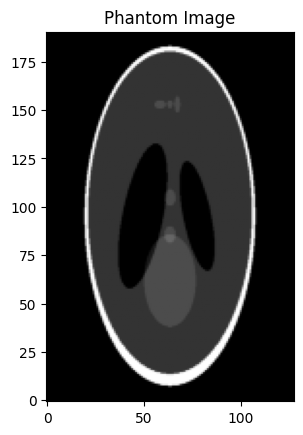

In [ ]:
# -- We use the functions in mrsigpy, as well as standard numpy and matpltlib
#! git clone https://github.com/mribri999/MRSignalsSeqs.git &> /dev/null # Clones the RAD229 repo
#import sys, os
#python_code_path = '/content/MRSignalsSeqs/Python/'
#sys.path.append(python_code_path) # To load the mrsigpy functions
#os.chdir(python_code_path) # Change directory to Python folder

import numpy as np
from Rad229_MRI_Phantom import rad229_mri_phantom
import matplotlib.pyplot as plt
from scipy.ndimage import shift

# Generate a phantom object
acq = {}
acq['Nx'] = 128  # Number of readout points
acq['Ny'] = 191  # Number of phase encode lines
acq['ESP'] = 500e-6  # Echo spacing [s]

# Generate a phantom object
phantom, mask = rad229_mri_phantom(acq)  # Make a Shepp-Logan phantom
phantom = np.array(phantom, dtype=complex)  # Cast phantom as complex

# Make  figure of the phantom
plt.figure
plt.imshow(np.abs(phantom), cmap='gray', origin='lower');
plt.title('Phantom Image');

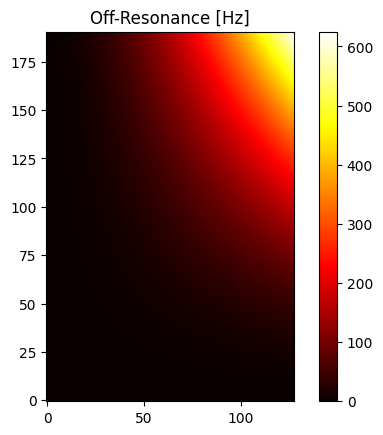

In [ ]:
# Create an off-resonance field

# Create a CONSTANT off-resonance frequency array (phase encode direction)
#off_x = np.linspace( 1 , 1 , acq['Nx'] );  # Arbitrary off-resonance frequency [Hz]
#off_y = np.linspace( 73 , 73 , acq['Ny'] );  # Arbitrary off-resonance frequency [Hz]

# Create a LINEAR off-resonance frequency array (phase encode direction)
#off_x = np.linspace( 1 , 1 , acq['Nx'] );  # Arbitrary off-resonance frequency [Hz]
#off_y = np.linspace( 0 , 250 , acq['Ny'] );  # Arbitrary off-resonance frequency [Hz]

# Create a LINEAR off-resonance frequency array (frequency encode direction)
#off_x = np.linspace( 0 , 250 , acq['Nx'] );  # Arbitrary off-resonance frequency [Hz]
#off_y = np.linspace( 1 , 1 , acq['Ny'] );  # Arbitrary off-resonance frequency [Hz]

# Create a QUADRATIC off-resonance frequency array
off_x = np.linspace(0, 5, acq['Nx'])**2  # Arbitrary off-resonance frequency [Hz]
off_y = np.linspace(0, 5, acq['Ny'])**2  # Arbitrary off-resonance frequency [Hz]

# Create a CUBIC off-resonance frequency array
#off_x = np.linspace(-2.5, 1.5, acq['Nx'])**3  # Arbitrary off-resonance frequency [Hz]
#off_y = np.linspace(-2.5, 2.0, acq['Ny'])**3  # Arbitrary off-resonance frequency [Hz]

# Create the off-resonance frequency grid across the FOV
off_xy = np.outer(off_y, off_x)  # Using np.outer to get the outer product

# Plot the results
plt.figure()
plt.imshow(off_xy, cmap='hot', aspect='equal', origin='lower')
plt.colorbar()
plt.title('Off-Resonance [Hz]')
plt.show()

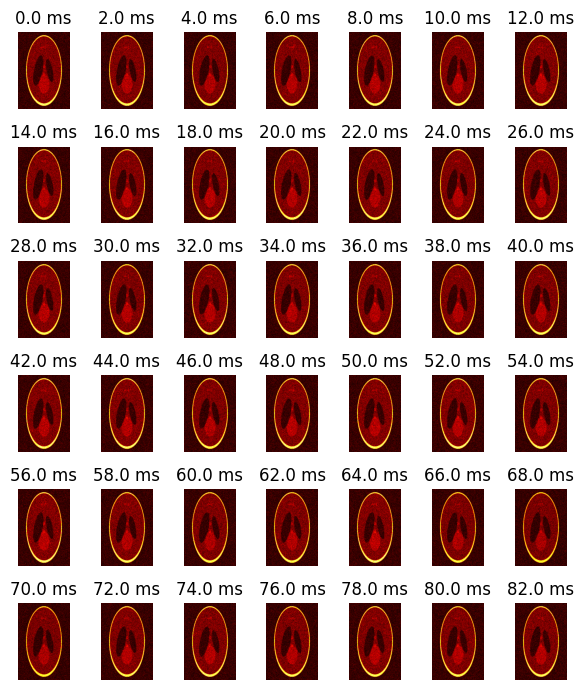

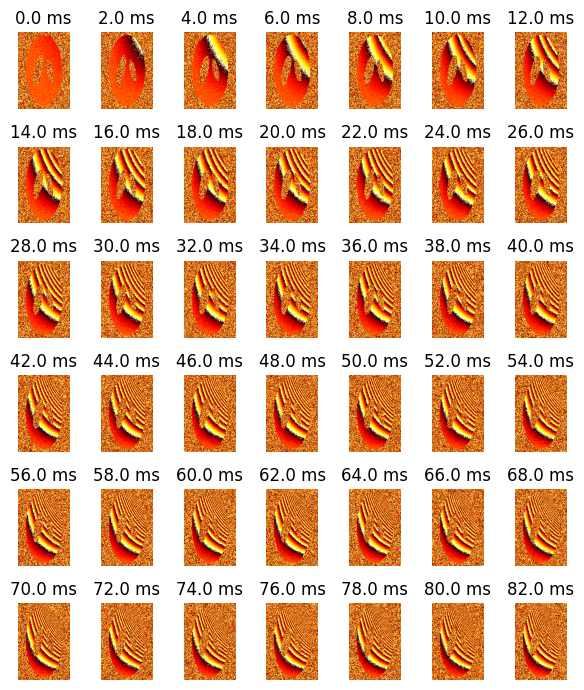

In [7]:
# Create a time series of phantoms, add off-resonance, add noise.

# Replicating P to match the required shape (need a time step for each phase encode line)
phantom_off = np.repeat(phantom[:, :, np.newaxis], acq['Ny'], axis=2)

# Loop to accumulate phase and apply it
for n in range(acq['Ny']):
    phs_off = np.exp(-1j * 2 * np.pi * off_xy * acq['ESP'] * (n + 1))  # Phase from off-resonance per echo
    phantom_off[:, :, n] = phantom_off[:, :, n] * phs_off  # Object accumulates phase during EPI duration

# Add some complex noise
phantom_off += (np.random.randn(*phantom_off.shape) + 1j * np.random.randn(*phantom_off.shape)) / 15

# Plot each n_sub phase in a subplot
n_sub = 4
n_rows = int(np.sqrt(acq['Ny'] / n_sub))
n_cols = n_rows + 1

# Plot the MAGNITUDE time-series
fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=(n_rows, n_cols))
axes = axes.flatten()  # Flatten axes for easy iteration
n_axes = len(axes.flatten())
max_axes = acq['Ny'] // n_sub  # Maximum allowed axes
n_axes = min(n_axes, max_axes)  # Ensure n_axes doesn't exceed max_axes

for i in range(n_axes):
    ax = axes[i]
    ax.imshow(np.abs( phantom_off[:, :, i * n_sub] ), cmap='hot', origin='lower')
    ax.set_title(f"{i * n_sub * acq['ESP'] * 1000:.1f} ms")
    ax.axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=(n_rows, n_cols))
axes = axes.flatten()  # Flatten axes for easy iteration
n_axes = len(axes.flatten())
max_axes = acq['Ny'] // n_sub  # Maximum allowed axes
n_axes = min(n_axes, max_axes)  # Ensure n_axes doesn't exceed max_axes

# Plot the PHASE time-series
for i in range(n_axes):
    ax = axes[i]
    ax.imshow(np.angle( phantom_off[:, :, i * n_sub] ), cmap='hot', origin='lower')
    ax.set_title(f"{i * n_sub * acq['ESP'] * 1000:.1f} ms")
    ax.axis('off')

plt.tight_layout()
plt.show()

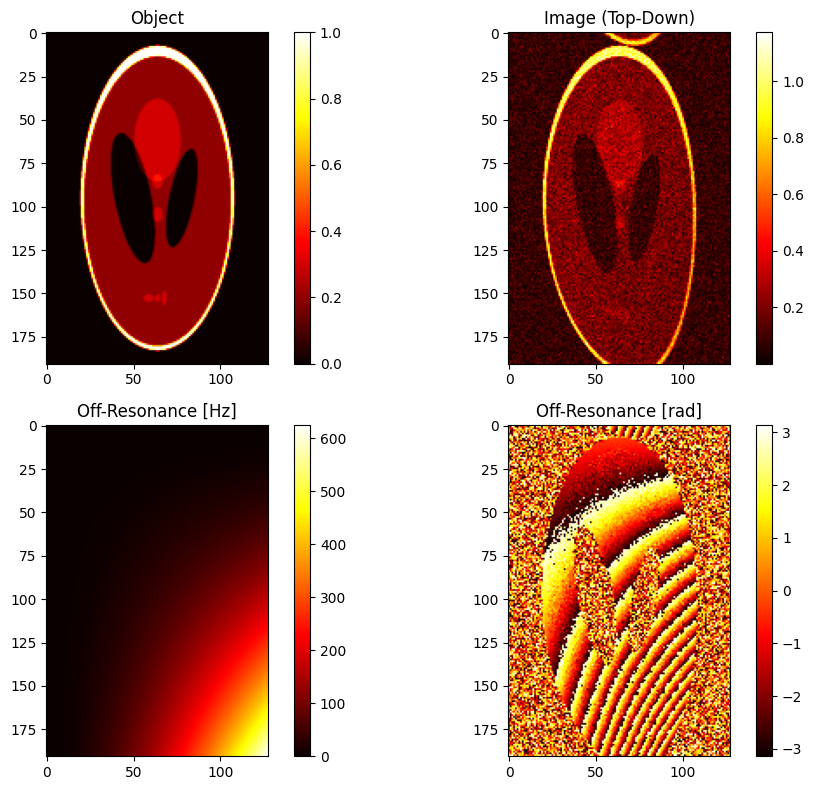

In [ ]:
# Generate the raw k-space and sampled k-space
 
# Initialize the output array with the same shape as P_off
kspc_dist = np.zeros_like(phantom_off, dtype=np.complex64)

# Loop through the time (third) dimension
for n in range(phantom_off.shape[2]):
    # Compute 2D FFT and shift zero-frequency component to the center
    kspc_dist[:, :, n] = np.fft.fftshift(np.fft.fft2(phantom_off[:, :, n]))

# Initialize kspc_epi_dist with appropriate shape (Nx, Ny) and complex dtype
kspc_epi_dist = np.zeros((acq['Ny'], acq['Nx']), dtype=np.complex64)

# Define the k-space ordering scheme
ind = np.arange(acq['Ny']) # TOP-DOWN k-space trajectory
#ind = acq['Ny'] - np.arange(acq['Ny']) - 1   # BOTTOM-UP k-space trajectory

for n in range(acq['Ny']):
    kspc_epi_dist[ind[n], :] = kspc_dist[ind[n], :, n]

# Reconstruct the distorted image
IM_epi_dist = np.fft.ifft2(np.fft.fftshift(kspc_epi_dist))

# Show the results
plt.figure(figsize=(10, 8))
plt.set_cmap('hot')  # Set colormap to 'hot'

# Subplot 1: Magnitude of the object
plt.subplot(2, 2, 1)
plt.imshow(np.abs(phantom), aspect='equal')
plt.title('Object')
plt.colorbar()

# Subplot 2: Magnitude of the distorted image
plt.subplot(2, 2, 2)
plt.imshow(np.abs(IM_epi_dist), aspect='equal')
plt.title('Image (Top-Down)')
plt.colorbar()

# Subplot 3: Off-resonance map in Hz
plt.subplot(2, 2, 3)
plt.imshow(off_xy, aspect='equal')
plt.title('Off-Resonance [Hz]')
plt.colorbar()

# Subplot 4: Phase of distorted image
plt.subplot(2, 2, 4)
plt.imshow(np.angle(IM_epi_dist), aspect='equal')
plt.title('Off-Resonance [rad]')
plt.colorbar()

plt.tight_layout()
plt.show()